In [55]:
import sys
print(sys.executable)

c:\Users\user\Downloads\IRS assignment(Arwa)VS\.venv\Scripts\python.exe


In [56]:
pip install pandas numpy matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [58]:
ratings = pd.read_csv('ratings.csv')
print(f"Number of users: {ratings['userId'].nunique():,}")
print(f"Number of Items: {ratings['movieId'].nunique():,}")
print(f"Number of ratings: {len(ratings):,}")

Number of users: 138,493
Number of Items: 26,744
Number of ratings: 20,000,263


In [59]:
ratings['rating'] = ratings['rating'].apply(lambda x: round(x))
ratings['rating'] = ratings['rating'].clip(lower=1, upper=5) #checking the ratings are within [1-5] interval
print(f"\nRating range: {ratings['rating'].min()} - {ratings['rating'].max()}")


Rating range: 1 - 5


In [60]:
user_rating_count = ratings.groupby('userId')['rating'].count().reset_index(name='nu')

In [65]:
item_ratings_count = ratings.groupby('movieId')['rating'].count().reset_index(name='ni')

In [66]:
user_ratings_avg = ratings.groupby('userId')['rating'].mean().reset_index(name='ru')

In [67]:
item_ratings_avg = ratings.groupby('movieId')['rating'].mean().reset_index(name='ri')

In [68]:
user_stats = user_rating_count.merge(user_ratings_avg, on='userId', how='outer') #merging the user satistics in one table
item_stats = item_ratings_count.merge(item_ratings_avg, on='movieId', how='outer')
final_data = ratings.copy() # to keep the original datafram unchanged
final_data = final_data.merge(user_stats, on='userId', how='left')
final_data = final_data.merge(item_stats, on='movieId', how='left')
final_data.to_csv('ratings_statistics.csv', index=False)

In [69]:
item_ratings_count_sorted = item_ratings_count.sort_values('ni', ascending=True)
print("Ascending order of the total number of ratings per item:")
print(item_ratings_count_sorted.head(10))

Ascending order of the total number of ratings per item:
       movieId  ni
26734   131241   1
26733   131239   1
26732   131237   1
26731   131231   1
26730   131180   1
26729   131176   1
26728   131174   1
26727   131172   1
26726   131170   1
26725   131168   1


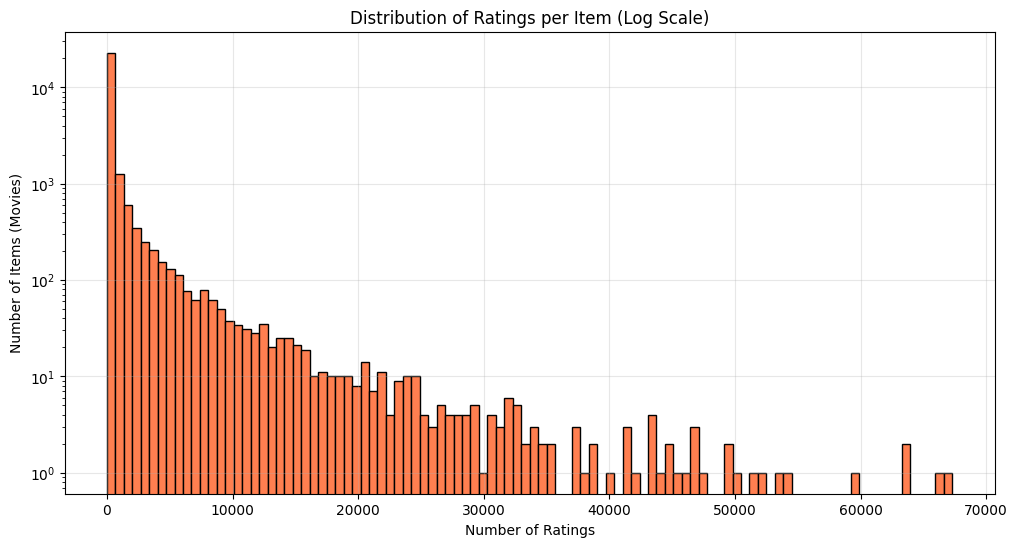

In [70]:
plt.figure(figsize=(12, 6))
plt.hist(item_ratings_count_sorted['ni'], bins=100, color='coral', edgecolor='black')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Items (Movies)')
plt.title('Distribution of Ratings per Item (Log Scale)')
plt.yscale('log')  # Use log scale for y-axis
plt.grid(True, alpha=0.3)
plt.show()

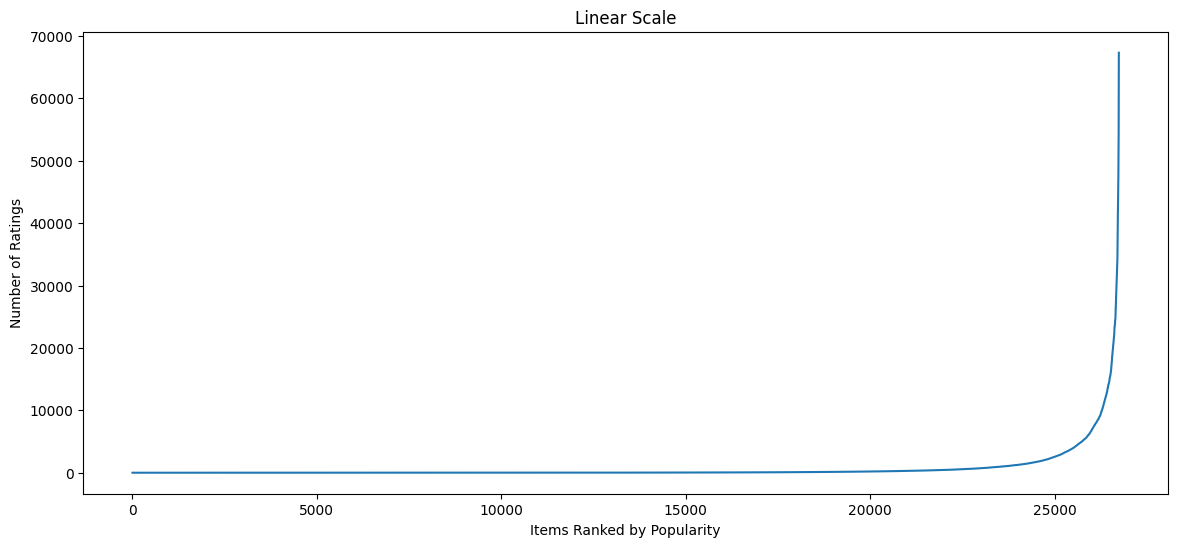

In [71]:
# Linear scale
plt.figure(figsize=(14, 6))
plt.plot(range(len(item_ratings_count_sorted)), item_ratings_count_sorted['ni'])
plt.title('Linear Scale')
plt.ylabel('Number of Ratings')
plt.xlabel('Items Ranked by Popularity')
plt.show()

In [72]:
item_ratings_avg['ri_percentage'] = (item_ratings_avg['ri'] / 5) * 100 #converting avg ratings to percentage

In [73]:
def assign_rating_group(ri_pct):
    if ri_pct <= 1:
        return 'G1 (≤1%)'
    elif ri_pct <= 5:
        return 'G2 (1-5%)'
    elif ri_pct <= 10:
        return 'G3 (5-10%)'
    elif ri_pct <= 20:
        return 'G4 (10-20%)'
    elif ri_pct <= 30:
        return 'G5 (20-30%)'
    elif ri_pct <= 40:
        return 'G6 (30-40%)'
    elif ri_pct <= 50:
        return 'G7 (40-50%)'
    elif ri_pct <= 60:
        return 'G8 (50-60%)'
    elif ri_pct <= 70:
        return 'G9 (60-70%)'
    else:
        return 'G10 (70-100%)'

In [74]:
item_ratings_avg['Group'] = item_ratings_avg['ri_percentage'].apply(assign_rating_group) #apply grouping

In [78]:
item_ratings_avg = item_ratings_avg.merge(item_ratings_count, on='movieId', how='left')
group_totals = (
    item_ratings_avg.groupby('Group')['ni']  # sum ni for each group
    .sum()
    .reset_index()
    .sort_values(by='ni', ascending=True)  # ascending order
)
print("Total number of ratings per group (ascending):")
print(group_totals)

Total number of ratings per group (ascending):
           Group        ni
1    G4 (10-20%)       450
2    G5 (20-30%)      3723
3    G6 (30-40%)     83512
4    G7 (40-50%)    471316
5    G8 (50-60%)   2095168
6    G9 (60-70%)   5350217
0  G10 (70-100%)  11995877


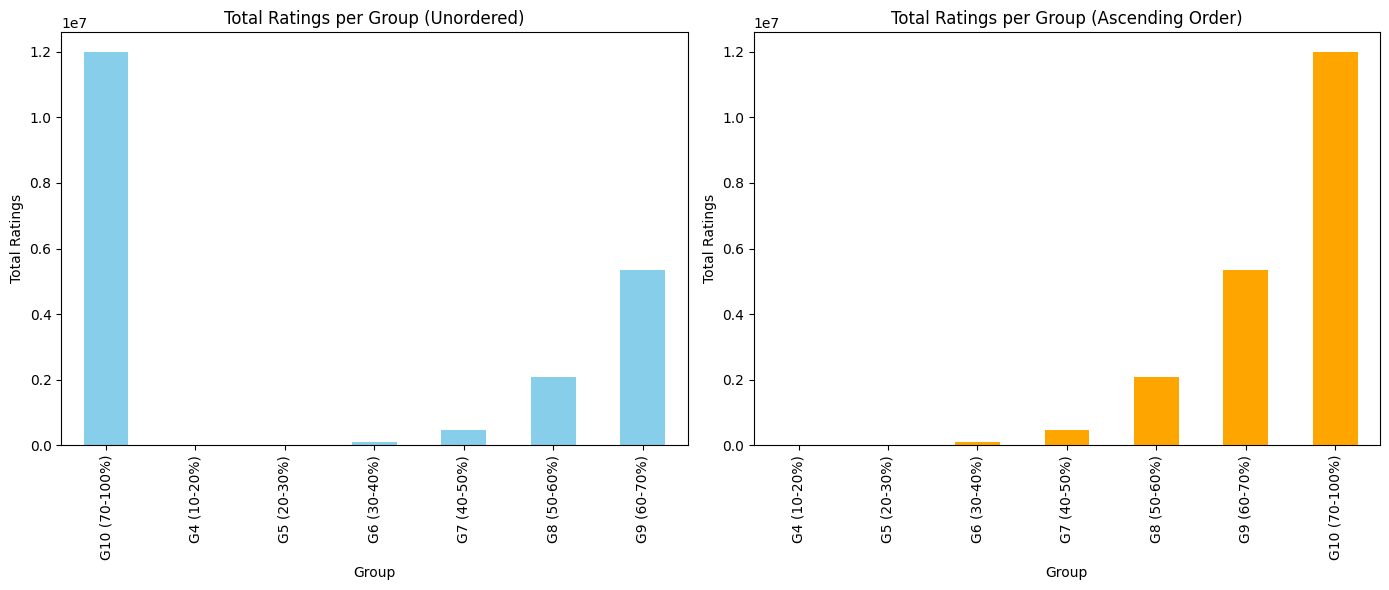

In [79]:
#total number of ratings per group (unordered)
group_totals_unordered = item_ratings_avg.groupby('Group')['ni'].sum()
#total number of ratings per group (ordered ascending)
group_totals_ordered = group_totals_unordered.sort_values(ascending=True)
plt.figure(figsize=(14, 6))
# Unordered
plt.subplot(1, 2, 1)
group_totals_unordered.plot(kind='bar', color='skyblue')
plt.title('Total Ratings per Group (Unordered)')
plt.ylabel('Total Ratings')
plt.xlabel('Group')
# Ordered
plt.subplot(1, 2, 2)
group_totals_ordered.plot(kind='bar', color='orange')
plt.title('Total Ratings per Group (Ascending Order)')
plt.ylabel('Total Ratings')
plt.xlabel('Group')
plt.tight_layout()
plt.show()

In [96]:
# Sort users by number of items rated
user_rating_count_sorted = user_rating_count.sort_values('nu')
# U1: lowest nu
U1 = int(user_rating_count_sorted.iloc[int(len(user_rating_count_sorted)*0.02)]['userId'])
# U2: medium nu (50th percentile)
U2 = int(user_rating_count_sorted.iloc[int(len(user_rating_count_sorted)*0.5)]['userId'])
# U3: high nu (90th percentile)
U3 = int(user_rating_count_sorted.iloc[int(len(user_rating_count_sorted)*0.9)]['userId'])
print("Target Users")
print("U1:", U1)
print("U2:", U2)
print("U3:", U3)

Target Users
U1: 12949
U2: 22806
U3: 63552


In [97]:
number_of_movies = ratings['movieId'].nunique() #the total
# Calculate the % of movies rated by each user
user_rating_percent = (user_rating_count['nu'] / number_of_movies) * 100
# Divide users into groups based on percentage of movies rated
u1_group = user_rating_percent[user_rating_percent <= 2]
u2_group = user_rating_percent[(user_rating_percent > 2) & (user_rating_percent <= 5)]
u3_group = user_rating_percent[(user_rating_percent > 5) & (user_rating_percent <= 10)]
U1 = int(u1_group.index[1])
U2 = int(u2_group.index[1])
U3 = int(u3_group.index[1])
# Combine target users into a Series
target_users = pd.Series([U1, U2, U3], index=['U1', 'U2', 'U3'], name='userId')
print("\nTarget Users:")
print(target_users)



Target Users:
U1      1
U2     57
U3    585
Name: userId, dtype: int64


In [100]:
# Sort items by average rating ascending
lowest_rated_items = item_ratings_count.sort_values('ni', ascending=True)
# Select the two lowest-rated items
I1 = int(lowest_rated_items.iloc[0]['movieId'])
I2 = int(lowest_rated_items.iloc[1]['movieId'])
print("Target Items:")
print("I1:", I1)
print("I2:", I2)


Target Items:
I1: 131241
I2: 131239
